In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from PIL import Image
from collections import Counter
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
torch.cuda.set_device(0)
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
masks = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)
        
series = list(zip(images, masks, labels))


In [3]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel(image_mask[2], fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

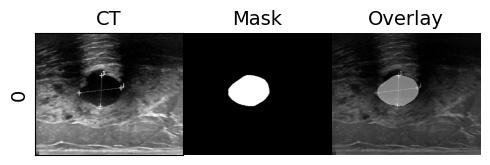

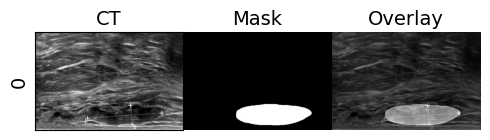

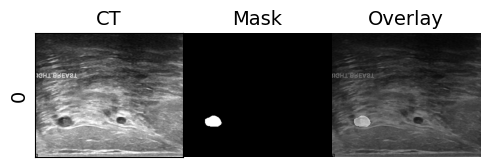

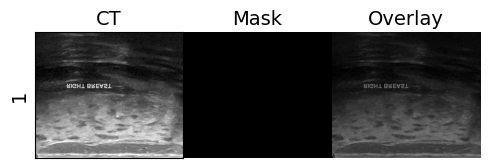

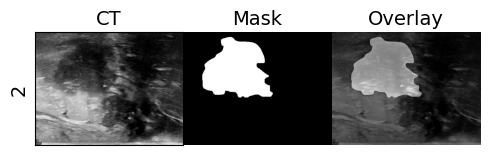

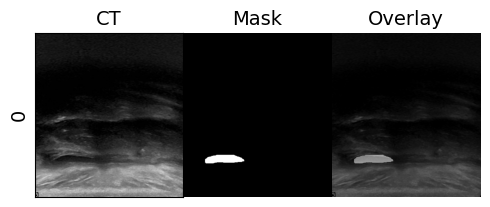

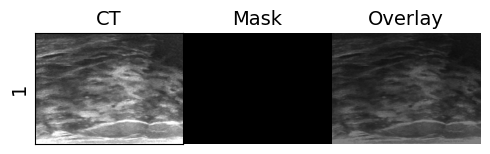

In [4]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [5]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [6]:
dataset = dataset[['image_path', 'labels']]

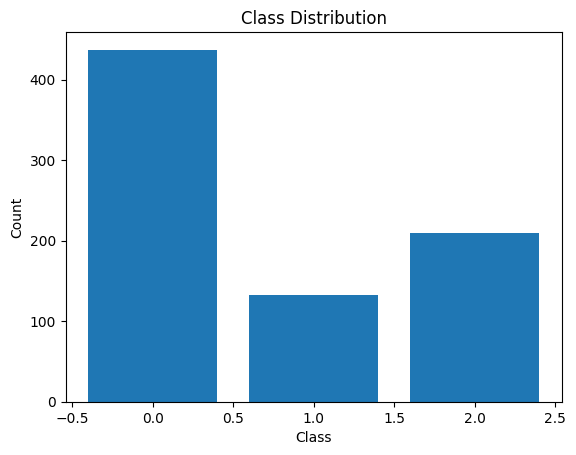

In [7]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [8]:
dataset

,image_path,labels
0,/kaggle/input/breast-ultrasound-images-dataset...,0
1,/kaggle/input/breast-ultrasound-images-dataset...,0
2,/kaggle/input/breast-ultrasound-images-dataset...,0
3,/kaggle/input/breast-ultrasound-images-dataset...,0
4,/kaggle/input/breast-ultrasound-images-dataset...,0
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset...,2
776,/kaggle/input/breast-ultrasound-images-dataset...,2
777,/kaggle/input/breast-ultrasound-images-dataset...,2
778,/kaggle/input/breast-ultrasound-images-dataset...,2


In [9]:
# Define paths
aug_path = '/kaggle/working/augmented_images/'
image_paths = dataset['image_path'].values
labels = dataset['labels'].values

# Create augmented data folder if it doesn't exist
if not os.path.exists(aug_path):
    os.makedirs(aug_path)

# Count the number of samples in each class
label_counts = Counter(labels)

# Calculate the target number of samples for each class (use the maximum count)
target_count = max(label_counts.values())

# Create image augmentation transforms
combined_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

In [10]:
for i in [1, 2]:
    num_augmentations = label_counts[0] + 220 - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    while num_augmentations > 0:
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        rotated_image = combined_transform(image.copy())

        rotated_image_np = np.array(rotated_image)
        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, rotated_image_np)
        num_augmentations -= 1

In [11]:
images = glob.glob("/kaggle/working/augmented_images/*.png")
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)
        
new_series = list(zip(images, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [12]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [13]:
concatenated_df

,image_path,labels
0,/kaggle/input/breast-ultrasound-images-dataset...,0
1,/kaggle/input/breast-ultrasound-images-dataset...,0
2,/kaggle/input/breast-ultrasound-images-dataset...,0
3,/kaggle/input/breast-ultrasound-images-dataset...,0
4,/kaggle/input/breast-ultrasound-images-dataset...,0
...,...,...
1091,/kaggle/working/augmented_images/malignant (4)...,2
1092,/kaggle/working/augmented_images/normal (103).png,1
1093,/kaggle/working/augmented_images/malignant (17...,2
1094,/kaggle/working/augmented_images/malignant (65...,2


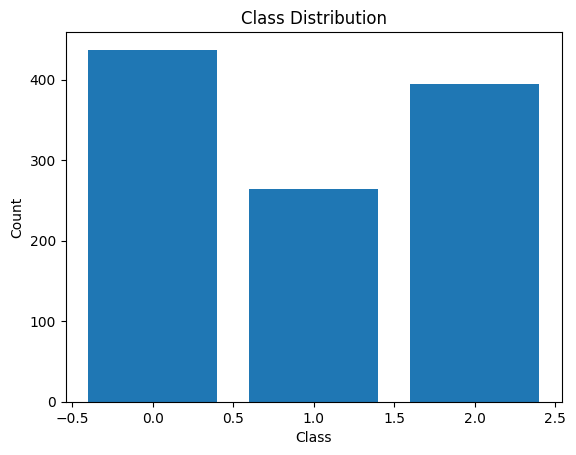

In [14]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [15]:
train, test= train_test_split(concatenated_df, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)

In [16]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB') 

        if self.image_transform:
            image = self.image_transform(image)

        return image, label

In [17]:
image_size = 256
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
import torch

class Trainer:
    def __init__(self, model, optimizer, criterion, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / len(val_loader.dataset)
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            # Save metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics


In [25]:
model = models.vgg16(pretrained=True)

In [26]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 3)
)

for param in model.parameters():
    if param.requires_grad:
        break
    else:
        for param in model.parameters():
            param.requires_grad = False

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
kjfkdlautjkjhelllo awsome sssjjfjfl;alskdjfjfkdls;atrainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())
trainer.train(train_dataloader, test_dataloader, num_epo4chs=20)

metrics = trainer.get_metrics()

Epoch 1/20 => Train Loss: 0.6621, Train Accuracy: 0.7210 | Val Loss: 0.5521, Val Accuracy: 0.6951
Epoch 2/20 => Train Loss: 0.5948, Train Accuracy: 0.7653 | Val Loss: 0.5256, Val Accuracy: 0.7927
Epoch 3/20 => Train Loss: 0.4235, Train Accuracy: 0.8527 | Val Loss: 0.5031, Val Accuracy: 0.7988
Epoch 4/20 => Train Loss: 0.3701, Train Accuracy: 0.8579 | Val Loss: 0.3663, Val Accuracy: 0.8293
Epoch 5/20 => Train Loss: 0.3562, Train Accuracy: 0.8787 | Val Loss: 0.4512, Val Accuracy: 0.8232
Epoch 6/20 => Train Loss: 0.3008, Train Accuracy: 0.9061 | Val Loss: 0.6403, Val Accuracy: 0.8354
Epoch 7/20 => Train Loss: 0.2350, Train Accuracy: 0.9074 | Val Loss: 0.4641, Val Accuracy: 0.8415
Epoch 8/20 => Train Loss: 0.2693, Train Accuracy: 0.9048 | Val Loss: 0.3840, Val Accuracy: 0.8537
Epoch 9/20 => Train Loss: 0.1938, Train Accuracy: 0.9296 | Val Loss: 0.3515, Val Accuracy: 0.8476
Epoch 10/20 => Train Loss: 0.3111, Train Accuracy: 0.9048 | Val Loss: 0.5883, Val Accuracy: 0.7988
Epoch 11/20 => Trai

In [34]:
# Test on Validation Set
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Val Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 87.88%


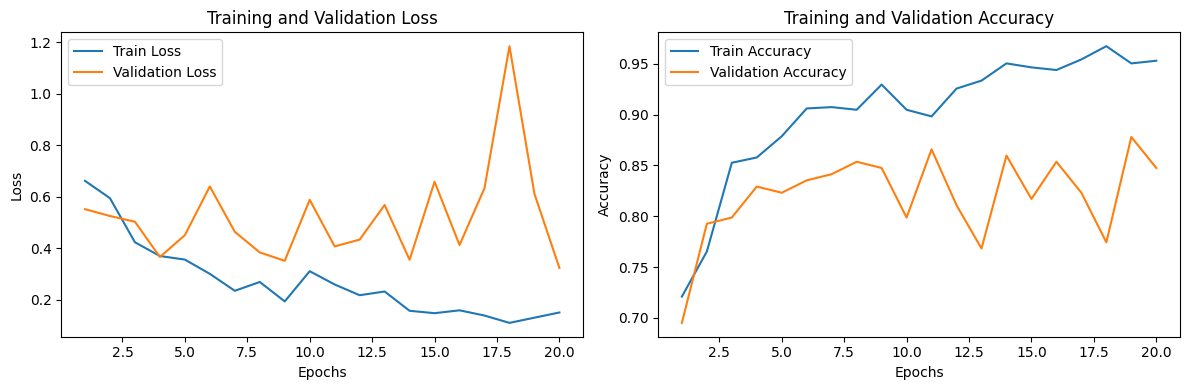

In [36]:

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(metrics)

In [37]:
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# Specify the number of layers to unfreeze
num_layers_to_unfreeze = 20  # You can modify this based on your requirements

# Unfreeze the specified number of layers
for param in list(vgg16.features.children())[-num_layers_to_unfreeze:]:
    param.requires_grad = True

# Define a new classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 1028),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1028, 512),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(512, 3)
)

# Replace the classifier
vgg16.classifier = classifier

vgg16.to(device)

# Assign the modified model to the variable 'model'
model = vgg16


In [38]:
trainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())
trainer.train(train_dataloader, test_dataloader, num_epochs=20)

metrics = trainer.get_metrics()

Epoch 1/20 => Train Loss: 1.0015, Train Accuracy: 0.5020 | Val Loss: 0.8791, Val Accuracy: 0.5854
Epoch 2/20 => Train Loss: 0.8011, Train Accuracy: 0.6102 | Val Loss: 0.8693, Val Accuracy: 0.5671
Epoch 3/20 => Train Loss: 0.6563, Train Accuracy: 0.7106 | Val Loss: 0.5995, Val Accuracy: 0.7500
Epoch 4/20 => Train Loss: 0.5712, Train Accuracy: 0.7823 | Val Loss: 0.5550, Val Accuracy: 0.7744
Epoch 5/20 => Train Loss: 0.4925, Train Accuracy: 0.8083 | Val Loss: 0.5363, Val Accuracy: 0.7866
Epoch 6/20 => Train Loss: 0.4826, Train Accuracy: 0.8031 | Val Loss: 0.6558, Val Accuracy: 0.7378
Epoch 7/20 => Train Loss: 0.4168, Train Accuracy: 0.8292 | Val Loss: 0.5087, Val Accuracy: 0.7866
Epoch 8/20 => Train Loss: 0.3863, Train Accuracy: 0.8540 | Val Loss: 0.5937, Val Accuracy: 0.7988
Epoch 9/20 => Train Loss: 0.3158, Train Accuracy: 0.8853 | Val Loss: 0.5891, Val Accuracy: 0.7927
Epoch 10/20 => Train Loss: 0.3381, Train Accuracy: 0.8657 | Val Loss: 0.5601, Val Accuracy: 0.7378
Epoch 11/20 => Trai

In [39]:
# Test on Validation Set
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Val Accuracy: {accuracy * 100:.2f}%')

Val Accuracy: 81.21%


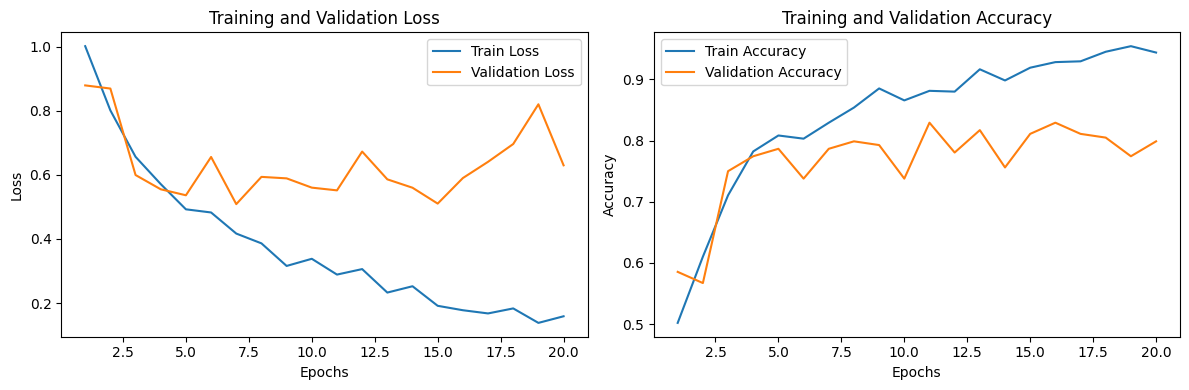

In [40]:
plot_metrics(metrics)